In [ ]:
#@title Setup

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ./subtitle
!unzip -q /content/drive/MyDrive/youtube-transcript/subtitle.zip -d ./subtitle
!pip -q install gluonnlp mxnet sentencepiece transformers
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-5eakjr2a/kobert-tokenizer_27a41407a56c4d3f93ec49d43f5c6c13
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-5eakjr2a/kobert-tokenizer_27a41407a56c4d3f93ec49d43f5c6c13
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=ba6e964b775d01fa10dc470b09fa21702e2e960dd03ed3a58bd86f6a88604f40
  Stored in directory: /tmp/pip-ephem-wheel-cache-56_xxcj2/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f

In [ ]:
#@title Get data from txt files

from glob import glob

def make_data(paths):
  data_list = []
  for path in paths:
    f = open(path, 'r')
    data, tmp = [], ""

    while True:
      line = f.readline()
      if not line: break
      if len(line) <= 1:
        data.append(tmp)
        tmp = ""
      else: tmp += line[:-1]

    data_list.append(data)
    f.close()

  return data_list

paths = glob('./subtitle/*.txt')
s1, s2 = int(len(paths) * 0.85), int(len(paths) * 0.95)
train_data_list = make_data(paths[:s1])
valid_data_list = make_data(paths[s1:s2])
test_data_list = make_data(paths[s2:])

In [ ]:
#@title Import module

from transformers import DistilBertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from kobert_tokenizer import KoBERTTokenizer
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import random
import os
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

device = torch.device("cuda:0")

In [ ]:
#@title Load KoBERT

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1',
                                            sp_model_kwargs={'nbest_size': -1, 'alpha': 0.6, 'enable_sampling': True})
bert = DistilBertModel.from_pretrained('skt/kobert-base-v1')

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of DistilBertModel were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['transformer.layer.11.attention.v_lin.bias', 'transformer.layer.3.output_layer_norm.bias', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.3.output_layer_norm.weight', 'transformer.layer.4.output_layer_norm.bias', 'transformer.layer.9.sa_layer_norm.bias', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.10.ffn.lin1.bias', 'transformer.layer.2.output_layer_norm.bias', 'transformer.layer.9.attention.k_lin.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.4.attention.q_lin.bias', 'transformer.layer.7.output_layer_norm.weight', 'transformer.layer.7.output_layer_norm.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.4.attention.v_lin.bias', 'transformer.layer.

In [ ]:
#@title Tokenizer test

print(tokenizer.decode([0, 1, 2, 3, 4]))

[UNK][PAD][CLS][SEP][MASK]


In [ ]:
s = train_data_list[0][0]
print('Text    : ', s)
print('Tokenize: ', tokenizer.tokenize(s))
enc = tokenizer.encode(s)
print('Encode  : ', enc)
print('Decode  : ', tokenizer.decode(enc))

Text    :  자 다음번 주제는 아르헨티나 입니다
Tokenize:  ['▁자', '▁다음', '번', '▁주제', '는', '▁아', '르', '헨', '티', '나', '▁', '입니다']
Encode  :  [2, 3886, 1577, 6328, 4239, 5760, 3093, 6113, 7896, 7673, 5655, 517, 7139, 3]
Decode  :  [CLS]자 다음번 주제는 아르헨티나 입니다[SEP]


In [ ]:
lens = []
cnt = 0
for data in train_data_list:
  for text in data:
    lens.append(len(tokenizer.encode(text)))
    cnt += 1

print(cnt, sum(lens) / cnt, max(lens), min(lens))

82207 15.671062075005779 70 2


In [ ]:
#@title Hyperparameter

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 50
learning_rate =  5e-5
dr_rate = 0.1
lambda_one = 4

In [ ]:
#@title Dataset

class BERTDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len):
    self.max_len = max_len

    self.group = []
    for data in dataset:
      now_text, now_label = [], []
      sep = []
      for text in data:
        enc = tokenizer.encode(text)[1:-1]
        label = [0] * (len(enc) - 1) + [1]
        now_text += enc
        now_label += label
        sep.append(len(now_text))

        while len(now_text) >= max_len-2:
          self.group.append((now_text[:(max_len-2)], now_label[:(max_len-2)], min(sep[0], max_len-2)))
          now_text = now_text[sep[0]:]
          now_label = now_label[sep[0]:]
          sep = [s - sep[0] for s in sep[1:]]

  def __getitem__(self, i):
    text, label, sep = self.group[i]
    e = random.randrange(sep, self.max_len-1)
    text = [2] + text[:e] + [3]
    label = [0] + label[:e] + [0]

    valid_len = len(text)
    pad_len = self.max_len - valid_len
    text += [1] * pad_len
    label += [0] * pad_len
    return (torch.Tensor(text), valid_len, torch.Tensor(label))

  def __len__(self):
    return len(self.group)

In [ ]:
train_dataset = BERTDataset(dataset=train_data_list, tokenizer=tokenizer, max_len=max_len)
valid_dataset = BERTDataset(dataset=valid_data_list, tokenizer=tokenizer, max_len=max_len)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
print(len(train_dataset), len(valid_dataset))
print(len(train_dataloader), len(valid_dataloader))

80895 9913
1264 155


In [ ]:
token_ids, valid_len, label = train_dataset[1300]
print(token_ids)
print(len(token_ids), valid_len)
print(tokenizer.decode(token_ids))

print([tokenizer.decode(int(id)) for id in token_ids])
print()

start = 0
for idx, lbl in enumerate(label):
  if lbl == 1:
    print(tokenizer.decode(token_ids[start:(idx+1)]))
    start = idx + 1

print(tokenizer.decode(token_ids[start:]))

tensor([2.0000e+00, 3.7420e+03, 3.4250e+03, 5.4390e+03, 3.8600e+03, 1.2010e+03,
        2.6930e+03, 6.0040e+03, 4.9770e+03, 2.8720e+03, 3.8670e+03, 3.8860e+03,
        3.6730e+03, 3.3950e+03, 1.3760e+03, 5.9380e+03, 5.1700e+02, 7.3800e+03,
        3.2190e+03, 5.9200e+03, 6.0720e+03, 5.7610e+03, 4.2330e+03, 1.1330e+03,
        5.9380e+03, 3.4660e+03, 5.6890e+03, 2.5800e+02, 3.5020e+03, 1.4210e+03,
        5.3770e+03, 5.9280e+03, 6.9990e+03, 3.2250e+03, 5.0100e+03, 5.1700e+02,
        5.9050e+03, 5.7710e+03, 2.5800e+02, 4.9610e+03, 7.0860e+03, 5.1700e+02,
        7.9060e+03, 6.0500e+02, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00])
64 45
[CLS]이제 오르고 있는 그런 상황이라고 할 수 있습니다 자 이렇게 옆 나라들을 쭉 얘기드렸는데 주요 국가들을 왜냐? 우리가 남아있거든요 어떻게 해야 됩니까? 한국은행은 현재 4[SEP][PAD][PAD][PAD][PAD][PAD][PAD][P

In [ ]:
#@title Model 1

class BERTClassifier(nn.Module):
  def __init__(self, bert, hidden_size=768, dr_rate=None):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dr_rate = dr_rate

    self.fc1 = nn.Linear(hidden_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, 1)
    self.tanh = nn.Tanh()

    if dr_rate: self.dropout = nn.Dropout(p=dr_rate)

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)

    output = self.bert(input_ids = token_ids,
                       attention_mask = attention_mask.float().to(token_ids.device))
    last_enc_layer = output[0]
    if self.dr_rate: last_enc_layer = self.dropout(last_enc_layer)
    return (self.tanh(self.fc2(self.relu(self.fc1(last_enc_layer)))) + 1.) * 0.5

In [ ]:
model = BERTClassifier(bert, dr_rate = dr_rate).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

In [ ]:
#@title Training

path = f'/content/drive/MyDrive/youtube-transcript/model/{lambda_one}_v3'
os.makedirs(path, exist_ok=True)

start_epoch = 0

if start_epoch == 0:
  train_lists = {'loss': [], 'acc': [], 'recall': [], 'precision': [], 'f1': []}
  valid_lists = {'loss': [], 'acc': [], 'recall': [], 'precision': [], 'f1': []}
else:
  optimizer.load_state_dict(f'{path}/optimizer.pt')
  model.load_state_dict(torch.load(f'{path}/model_{start_epoch-1}.pt'))
  with open(f'{path}/lists.pkl', 'rb') as f:
    train_lists, valid_lists = pickle.load(f)

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step,
                                            num_training_steps=t_total, last_epoch=start_epoch-1)

for epoch in range(start_epoch, num_epochs):
  loss_sum, acc_sum, recall_sum, precision_sum, f1_sum, n, nl = 0., 0., 0., 0., 0., 0, 0
  model.train()
  for batch_id, (token_ids, valid_length, label) in enumerate(train_dataloader):
    bs = label.shape[0]
    optimizer.zero_grad()

    token_ids = token_ids.long().to(device)
    label = label.long().to(device)
    weight = torch.ones_like(label).to(device)
    weight[label > 0.5] = lambda_one  # weight for lable=1
    weight[torch.logical_and(token_ids < 5, token_ids > 0)] = 0  # mask padding

    out = model(token_ids, valid_length).squeeze(-1)
    loss = (weight * (out - label).pow(2)).mean()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()

    # delete special tokens
    token_ids = token_ids.view(-1)
    label = label.view(-1)[torch.logical_or(token_ids > 4, token_ids < 1)].cpu()
    out = (out > 0.5).view(-1)[torch.logical_or(token_ids > 4, token_ids < 1)].cpu().detach()

    acc = accuracy_score(label, out)
    recall = recall_score(label, out, zero_division=0.0)
    precision = precision_score(label, out, zero_division=0.0)
    f1 = f1_score(label, out, zero_division=0.0)

    train_lists['loss'].append(loss.item())
    train_lists['acc'].append(acc)
    train_lists['recall'].append(recall)
    train_lists['precision'].append(precision)
    train_lists['f1'].append(f1)

    nl += label.shape[0]
    loss_sum += loss.item() * token_ids.shape[0]

    n += bs
    acc_sum += acc * bs
    recall_sum += recall * bs
    precision_sum += precision * bs
    f1_sum += f1 * bs

    if (batch_id + 1) % log_interval == 0:
      print("[epoch %2d] [train %4d] loss: %.4f, acc: %.4f, recall: %.4f, precision: %.4f, f1: %.4f"
            % (epoch+1, batch_id+1, loss_sum/nl, acc_sum/n, recall_sum/n, precision_sum/n, f1_sum/n))
      loss_sum, acc_sum, recall_sum, precision_sum, f1_sum, n, nl = 0., 0., 0., 0., 0., 0, 0

  loss_sum, acc_sum, recall_sum, precision_sum, f1_sum, n, nl = 0., 0., 0., 0., 0., 0, 0
  model.eval()
  for batch_id, (token_ids, valid_length, label) in enumerate(valid_dataloader):
    bs = label.shape[0]
    token_ids = token_ids.long().to(device)
    label = label.long().to(device)
    weight = torch.ones_like(label).to(device)
    weight[label > 0.5] = lambda_one
    weight[torch.logical_and(token_ids < 5, token_ids > 0)] = 0

    out = model(token_ids, valid_length).squeeze(-1)
    loss = (weight * (out - label).pow(2)).mean()

    # label = label.view(-1).cpu()
    # out = (out > 0.5).view(-1).cpu()
    token_ids = token_ids.view(-1)
    label = label.view(-1)[torch.logical_or(token_ids > 4, token_ids < 1)].cpu()
    out = (out > 0.5).view(-1)[torch.logical_or(token_ids > 4, token_ids < 1)].cpu()

    nl += label.shape[0]
    loss_sum += loss.item() * token_ids.shape[0]

    n += bs
    acc_sum += accuracy_score(label, out) * bs
    recall_sum += recall_score(label, out, zero_division=0.0) * bs
    precision_sum += precision_score(label, out, zero_division=0.0) * bs
    f1_sum += f1_score(label, out, zero_division=0.0) * bs

  valid_lists['loss'].append(loss_sum/nl)
  valid_lists['acc'].append(acc_sum/n)
  valid_lists['recall'].append(recall_sum/n)
  valid_lists['precision'].append(precision_sum/n)
  valid_lists['f1'].append(f1_sum/n)

  print("[epoch %2d] [test] loss: %.4f, acc: %.4f, recall: %.4f, precision: %.4f, f1: %.4f"
        % (epoch+1, loss_sum/nl, acc_sum/n, recall_sum/n, precision_sum/n, f1_sum/n))

  torch.save(model.state_dict(), f'{path}/model_{epoch+1}.pt')
  torch.save(optimizer.state_dict(), f'{path}/optimizer.pt')
  with open(f'{path}/lists.pkl', 'wb') as f:
    pickle.dump((train_lists, valid_lists), f)

[epoch  1] [train   50] loss: 0.2662, acc: 0.6050, recall: 0.2912, precision: 0.3151, f1: 0.2568
[epoch  1] [train  100] loss: 0.0690, acc: 0.9649, recall: 0.7864, precision: 0.7081, f1: 0.7262
[epoch  1] [train  150] loss: 0.0500, acc: 0.9552, recall: 0.8763, precision: 0.5570, f1: 0.6801
[epoch  1] [train  200] loss: 0.0593, acc: 0.9582, recall: 0.8544, precision: 0.6862, f1: 0.7504
[epoch  1] [train  250] loss: 0.0653, acc: 0.9460, recall: 0.8614, precision: 0.6032, f1: 0.6903
[epoch  1] [train  300] loss: 0.0507, acc: 0.9658, recall: 0.8548, precision: 0.6997, f1: 0.7639
[epoch  1] [train  350] loss: 0.0660, acc: 0.9473, recall: 0.8751, precision: 0.6336, f1: 0.7178
[epoch  1] [train  400] loss: 0.0516, acc: 0.9548, recall: 0.8768, precision: 0.5932, f1: 0.6988
[epoch  1] [train  450] loss: 0.0446, acc: 0.9617, recall: 0.8805, precision: 0.6212, f1: 0.7259
[epoch  1] [train  500] loss: 0.0984, acc: 0.9450, recall: 0.7155, precision: 0.6118, f1: 0.6529
[epoch  1] [train  550] loss: 

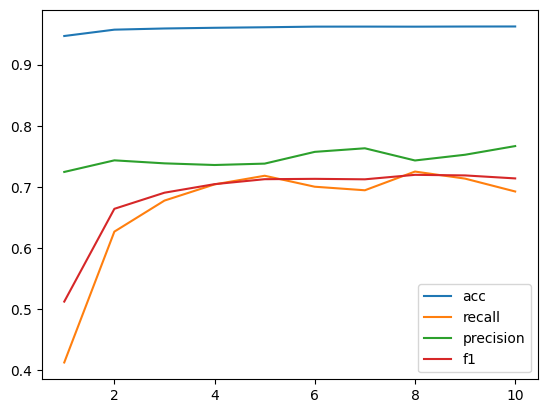

In [ ]:
import matplotlib.pyplot as plt

n = num_epochs
plt.plot(range(1, n+1), valid_lists['acc'], label='acc')
plt.plot(range(1, n+1), valid_lists['recall'], label='recall')
plt.plot(range(1, n+1), valid_lists['precision'], label='precision')
plt.plot(range(1, n+1), valid_lists['f1'], label='f1')
plt.legend()
plt.show()

In [ ]:
#@title Load model

model = BERTClassifier(bert, dr_rate = dr_rate).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/youtube-transcript/model/2_v3/model_8.pt'))

<All keys matched successfully>

In [ ]:
with open(f'/content/drive/MyDrive/youtube-transcript/model/2_v3/lists.pkl', 'rb') as f:
  train_lists, valid_lists = pickle.load(f)

for idx, v in enumerate(valid_lists['f1']):
  print('%d: %.4f' % (idx+1, v))

In [ ]:
#@title Test on one example of test set

model.eval()

now_text, now_label = [], []
for text in test_data_list[2]:
  enc = tokenizer.encode(text)[1:-1]
  label = [0] * (len(enc) - 1) + [1]
  now_text += enc
  now_label += label

  while len(now_text) >= max_len - 2:
    temp_text = [2] + now_text[:(max_len-2)] + [3]
    temp_label = now_label[:(max_len-2)]

    token_ids = torch.Tensor(temp_text).long().unsqueeze(0).to(device)
    out = model(token_ids, [max_len]).squeeze(-1).squeeze(0)[1:(max_len-1)]

    token_ids = token_ids.squeeze(0)[1:(max_len-1)]
    start = 0
    for idx, lbl in enumerate(out):
      if lbl > 0.5:
        print(tokenizer.decode(token_ids[start:(idx+1)]), end=' / ')
        start = idx + 1

    print(tokenizer.decode(token_ids[start:]))

    start = 0
    for idx, lbl in enumerate(temp_label):
      if lbl > 0.5:
        print(tokenizer.decode(token_ids[start:(idx+1)]), end=' / ')
        start = idx + 1

    print(tokenizer.decode(token_ids[start:]))

    now_text = enc
    now_label = label

자, 봅시다 / 그 다음은 이제 또 또 안 좋은 내용이네 / 역대 1위라고 불리우는 3천억 / 횡령 사건이 대한민국에서 또 발생을 했다 / 아니, 아니, 아니 웬만한 숫자로는 제가 안 놀래거든요 / 300억 이런 걸
자, 봅시다 그 다음은 이제 또 또 안 좋은 내용이네 / 역대 1위라고 불리우는 3천억 / 횡령 사건이 대한민국에서 또 발생을 했다 / 아니, 아니, 아니 웬만한 숫자로는 제가 안 놀래거든요 / 300억 이런 걸
300억 이런 걸로는 이제 흔들리지도 않아요 / 그냥 건너가 에이, 300억은 뭐 누구 집 애 이름인가? 넘어가는데 / 천억 정도면 조금 쳐다보는데 / 3천억 횡령 사건이 발생을 했다라는 뉴스가 있습니다 / 이게 9월 20
300억 이런 걸로는 이제 흔들리지도 않아요 / 그냥 건너가 / 에이, 300억은 뭐 / 누구 집 애 이름인가? 넘어가는데 / 천억 정도면 조금 쳐다보는데 / 3천억 횡령 사건이 발생을 했다라는 뉴스가 있습니다 / 이게 9월 20
이게 9월 20일 날 원래 천억짜리라고 제가 알고 있었는데 / 갑자기 금융감독원이 보도자료를 냈는데 / 여기에 2,988억 원을 횡령한 사실을 확인했다라고 적혀있죠 / 이게 처음에는 1,100억인가 이렇게 알려졌어요 / 
이게 9월 20일 날 / 원래 천억짜리라고 제가 알고 있었는데 / 갑자기 금융감독원이 보도자료를 냈는데 / 여기에 2,988억 원을 / 횡령한 사실을 확인했다라고 적혀있죠 / 이게 처음에는 1,100억인가 이렇게 알려졌어요 / 
이게 처음에는 1,100억인가 이렇게 알려졌어요 / 1,100억짜리 횡령이 있었다 / 그것도 크구만 그런데 갑자기 보도자료를 냈는데 / 3배가 됐네 / 2,988억 보시면 은행에서 발생한 PF대출 횡령사고에 대해서
이게 처음에는 1,100억인가 이렇게 알려졌어요 / 1,100억짜리 횡령이 있었다 / 그것도 크구만 / 그런데 갑자기 보도자료를 냈는데 / 3배가 됐네 / 2,988억 / 보시면 은행에서 발생한 PF대출 / 횡령사고에 대해서
횡령사고에 대해

In [ ]:
#@title Test with post processing

text = " ".join(test_data_list[0])
print(text)

model.eval()
enc = tokenizer.encode(text)

now_text, now_label = [], []
idx = 0
while idx < len(enc):
  temp_text = [2] + enc[idx:(idx + max_len - 2)] + [3]
  token_ids = torch.Tensor(temp_text).long().unsqueeze(0).to(device)
  out = model(token_ids, [max_len]).squeeze(-1).squeeze(0)[1:(max_len-1)]

  token_ids = token_ids.squeeze(0)[1:(max_len-1)]

  start = 0
  for i, lbl in enumerate(out):
    if lbl > 0.5:
      print(tokenizer.decode(token_ids[start:(i+1)]))
      start = i + 1

  idx += start

자, 여러분 안녕하세요 자, 오늘의 주인공은 여러분들이 앞에서 보셨듯이 토스뱅크 입니다 자, 본격적인 이야기를 하기에 앞서 요 사진이 아마 여러분들 눈에 익으실 겁니다 우리나라 각종 언론에 정말 많이 나온 사진인데요 최근에 무슨 사진입니까? 바로 수원 전세 사기 피의자와 세입자들이 실랑이를 벌이는 모습입니다 전세 사기 피의자, 피의자 분들이 어제 나와서 택시를 타셨는데 옆에 전세 사기 피해자, 세입자들 피해를 봤다는 분들이 둘러싸고 이제 실랑이, 항의를 하는 거죠 내 돈 돌려달라고 항의를 하는 모습인데 결국에 경찰이 출동을 하고 나서야 이 소동이 좀 가라앉았다고 합니다 아마 뉴스에서 보셨겠지만 이번에 수원에서 또다시 전세 사기 사건이 발생했습니다 무려 18개 법인을 세우고 51개 건물을 소유한 어떻게 보면 자산가죠 이 사람이 정말 많은 전세를 내주고 피해를 입혔죠 현재까지 피해가 확인된 세대가 거의 400세대에 육박하고 있습니다 점점 늘어나는 추세이기 때문에 현재 394세대지만 400세대를 넘을 것 같고요 피해액도 지금 눈덩이처럼 불어나고 있습니다 처음에는 300억에서 시작했다가 지금은 800억 이상을 추정을 하고 있습니다 또다시 발생한 사건이라고 할 수 있는데요 게다가 이번에 더욱 안타까웠던 게 피해자들이 등기부 등본을 꽤 꼼꼼히 살펴봤지만 피해를 막지 못했다는 점에 있습니다 전세 사기가 우리 사회에 이슈가 된 지가 꽤 됐기 때문에 이번 피해자분들은 등기부등본을 좀 봤대요 봤는데도 알 수가 없었다는 겁니다 왜냐하면 분명히 내가 본 등기부등본상의 대출은 한 7억 원대가 잡혀있었다고 합니다 건물이 근데 건물은 14억, 15억짜리니까 절반밖에 안 잡혀있구만 나는 안전하겠어 라고 생각했는데 그게 아니라는 거죠 무슨 말입니까? 세대가 여러 개 있으니까 여러 세대에 쪼개져서 대출을 피의자가 공동 담보를 잡아서 대출을 여러 군데 쪼개서 했던 거죠 그 대출을 합쳐보니까 전체 20억 원이 넘었다고 그럽니다 이른바 쪼개기 대출이라고 하는 건데 아마 처음 들어보신 분도 있을 겁

In [ ]:
#@title Ground-truth

for t in test_data_list[0]:
  print(t)

자, 여러분 안녕하세요
자, 오늘의 주인공은 여러분들이 앞에서 보셨듯이 토스뱅크 입니다
자, 본격적인 이야기를 하기에 앞서
요 사진이 아마 여러분들 눈에 익으실 겁니다
우리나라 각종 언론에 정말 많이 나온 사진인데요 최근에
무슨 사진입니까?
바로 수원 전세 사기 피의자와 세입자들이 실랑이를 벌이는 모습입니다
전세 사기 피의자, 피의자 분들이 어제 나와서 택시를 타셨는데
옆에 전세 사기 피해자, 세입자들
피해를 봤다는 분들이 둘러싸고 이제 실랑이, 항의를 하는 거죠
내 돈 돌려달라고 항의를 하는 모습인데
결국에 경찰이 출동을 하고 나서야 이 소동이 좀 가라앉았다고 합니다
아마 뉴스에서 보셨겠지만
이번에 수원에서 또다시 전세 사기 사건이 발생했습니다
무려 18개 법인을 세우고 51개 건물을 소유한
어떻게 보면 자산가죠
이 사람이 정말 많은 전세를 내주고 피해를 입혔죠
현재까지 피해가 확인된 세대가
거의 400세대에 육박하고 있습니다
점점 늘어나는 추세이기 때문에
현재 394세대지만 400세대를 넘을 것 같고요
피해액도 지금 눈덩이처럼 불어나고 있습니다
처음에는 300억에서 시작했다가
지금은 800억 이상을 추정을 하고 있습니다
또다시 발생한 사건이라고 할 수 있는데요
게다가 이번에 더욱 안타까웠던 게
피해자들이 등기부 등본을 꽤 꼼꼼히 살펴봤지만
피해를 막지 못했다는 점에 있습니다
전세 사기가 우리 사회에 이슈가 된 지가 꽤 됐기 때문에
이번 피해자분들은 등기부등본을 좀 봤대요
봤는데도 알 수가 없었다는 겁니다
왜냐하면 분명히 내가 본 등기부등본상의 대출은
한 7억 원대가 잡혀있었다고 합니다 건물이
근데 건물은 14억, 15억짜리니까 절반밖에 안 잡혀있구만
나는 안전하겠어 라고 생각했는데
그게 아니라는 거죠
무슨 말입니까? 세대가 여러 개 있으니까
여러 세대에 쪼개져서 대출을 피의자가 공동 담보를 잡아서
대출을 여러 군데 쪼개서 했던 거죠
그 대출을 합쳐보니까 전체 20억 원이 넘었다고 그럽니다
이른바 쪼개기 대출이라고 하는 건데
아마 처음 들어보신 분도 있을 겁

In [ ]:
#@title Test performance

test_dataset = BERTDataset(dataset=test_data_list, tokenizer=tokenizer, max_len=max_len)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

loss_sum, acc_sum, recall_sum, precision_sum, f1_sum, n = 0., 0., 0., 0., 0., 0
model.eval()
for batch_id, (token_ids, valid_length, label) in enumerate(test_dataloader):
  bs = label.shape[0]
  token_ids = token_ids.long().to(device)
  label = label.long().to(device)

  out = model(token_ids, valid_length).squeeze(-1)
  # label = label.view(-1).cpu()
  # out = (out > 0.5).view(-1).cpu()

  token_ids = token_ids.view(-1)
  label = label.view(-1)[torch.logical_or(token_ids > 4, token_ids < 1)].cpu()
  out = (out > 0.5).view(-1)[torch.logical_or(token_ids > 4, token_ids < 1)].cpu()

  acc_sum += accuracy_score(label, out) * bs
  recall_sum += recall_score(label, out) * bs
  precision_sum += precision_score(label, out) * bs
  f1_sum += f1_score(label, out) * bs
  n += bs

print("acc: %.4f, recall: %.4f, precision: %.4f, f1: %.4f"
      % (acc_sum/n, recall_sum/n, precision_sum/n, f1_sum/n))

acc: 0.9642, recall: 0.7374, precision: 0.7321, f1: 0.7291


[1] acc: 0.9642, recall: 0.7374, precision: 0.7321, f1: 0.7291  
[2] acc: 0.9671, recall: 0.7810, precision: 0.7300, f1: 0.7517  
[3] acc: 0.9579, recall: 0.8092, precision: 0.6401, f1: 0.7051  
[5] acc: 0.9547, recall: 0.8387, precision: 0.6112, f1: 0.6956  
[10] acc: 0.9264, recall: 0.8239, precision: 0.4880, f1: 0.6041  
[15] acc: 0.9282, recall: 0.9263, precision: 0.5023, f1: 0.6424  